In [18]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


In [19]:

df = pd.read_csv('Equal.csv', encoding='latin-1')

min_count = df['Sentiment'].value_counts().min()
df = df.groupby('Sentiment').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

print(df['Sentiment'].value_counts())


Sentiment
negative    25001
neutral     25001
positive    25001
Name: count, dtype: int64


C:\Users\Laptop Land\AppData\Local\Temp\ipykernel_2480\585430346.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Sentiment').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [20]:

# lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    # words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

df['Summary'] = df['Summary'].fillna('').apply(clean_text)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce').fillna(0).astype(int)


In [21]:

X = df[['Summary', 'Rate']]
y = df['Sentiment']
classes = sorted(y.unique())
y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

In [22]:

X_train, X_test, y_train_labels, y_test_labels, y_train, y_test = train_test_split(
    X, y, y_bin, test_size=0.2, random_state=42
)


In [23]:

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Summary'),
    ('scaler', StandardScaler(), ['Rate'])
])


In [24]:

model = Pipeline([
    ('pre', preprocessor),
    ('clf', OneVsRestClassifier( DecisionTreeClassifier(max_depth=5, random_state=42)))
        # RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_labels = [classes[i.argmax()] for i in y_pred]


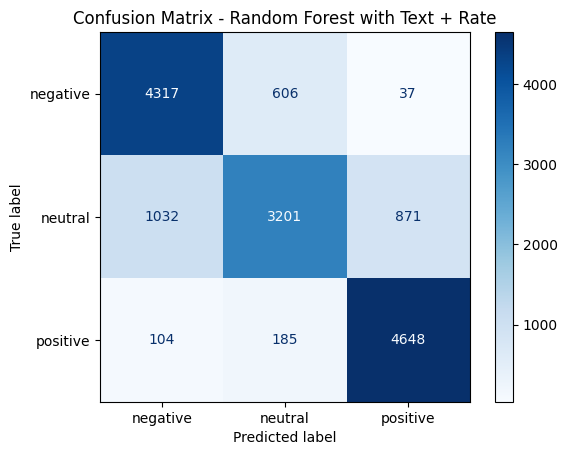

In [25]:

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest with Text + Rate")
plt.show()


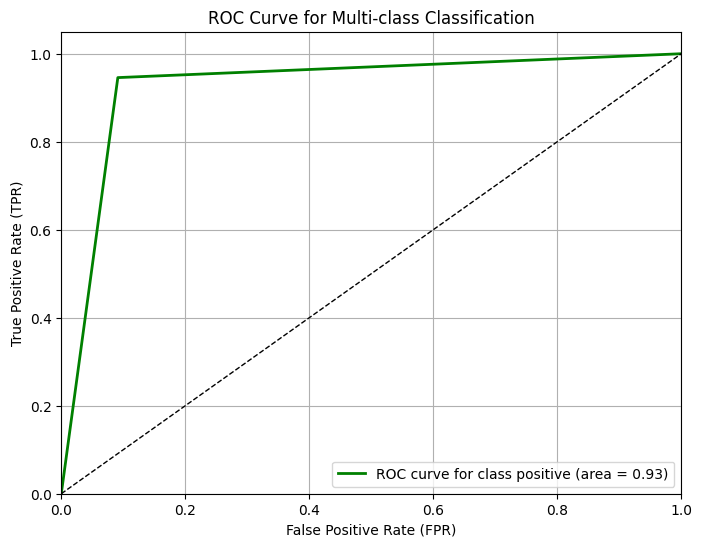

In [26]:

fpr = dict()
tpr = dict()
roc_auc = dict()

# for i in range(n_classes):
fpr[2], tpr[2], _ = roc_curve(y_test[:, 2], y_pred[:, 2])
roc_auc[2] = auc(fpr[2], tpr[2])

plt.figure(figsize=(8, 6))
colors = ['green']
# for i, color in zip(range(n_classes), colors):
plt.plot(fpr[2], tpr[2], color='green', lw=2,
         label=f"ROC curve for class {classes[2]} (area = {roc_auc[2]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Multi-class Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Summary'),
    ('scaler', MinMaxScaler(), ['Rate'])
])
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "Naïve Bayes": MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

for name, clf in models.items():
    model = Pipeline([
        ('pre', preprocessor),
        ('clf', OneVsRestClassifier(clf))
     ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_labels = [classes[i.argmax()] for i in y_pred]

    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test_labels, y_pred_labels))
    results["Precision"].append(precision_score(y_test_labels, y_pred_labels, average='macro'))
    results["Recall"].append(recall_score(y_test_labels, y_pred_labels, average='macro'))
    results["F1-score"].append(f1_score(y_test_labels, y_pred_labels, average='macro'))

results_df = pd.DataFrame(results)
print(results_df)


           Model  Accuracy  Precision    Recall  F1-score
0  Random Forest  0.712686   0.806612  0.716066  0.701369
1    Naïve Bayes  0.764616   0.784060  0.766768  0.760642
2  Decision Tree  0.811013   0.810034  0.812994  0.806302


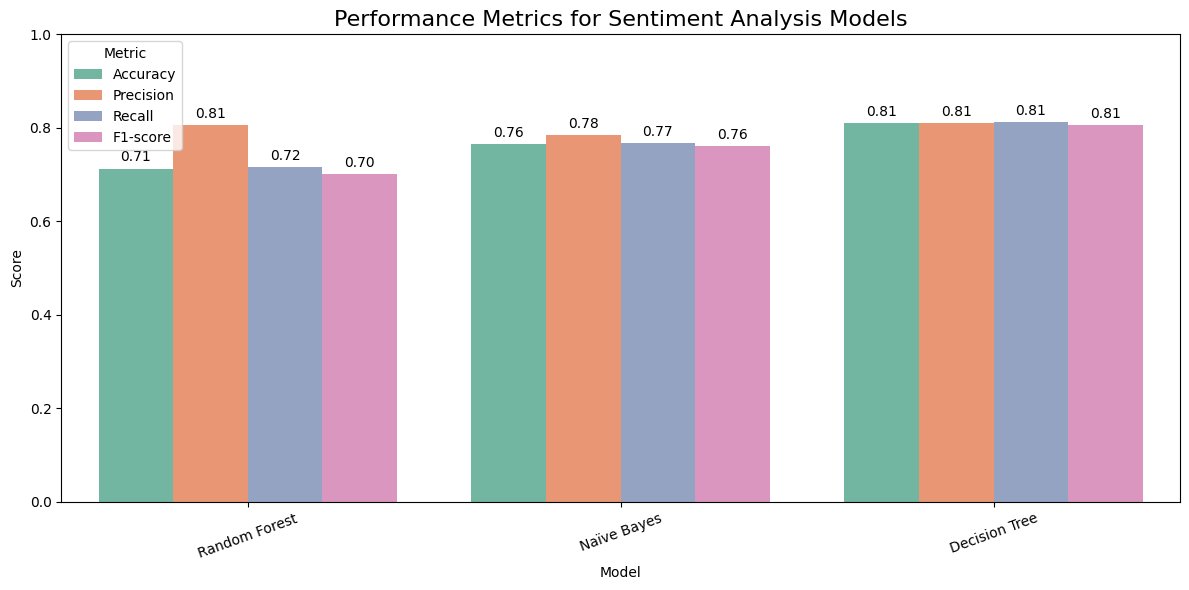

In [28]:
# تحويل النتائج إلى شكل Long Format
results_long = pd.melt(results_df, id_vars=["Model"], 
                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                       var_name="Metric", value_name="Score")

# رسم المخطط الموحد
plt.figure(figsize=(12, 6))
sns.barplot(data=results_long, x="Model", y="Score", hue="Metric", palette="Set2")

# تحسين العرض
plt.title("Performance Metrics for Sentiment Analysis Models", fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=20)

# عرض القيم على الأعمدة
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.legend(title="Metric")
plt.tight_layout()
plt.show()